In [1]:
#python import statements

import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
import itertools

In [2]:
#qiskit import statements

from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info import random_statevector, Statevector
import qiskit.quantum_info as qi
from qiskit.circuit import Parameter #allows us to have parameterized gates
from qiskit.extensions import UnitaryGate

# Use Aer's qasm_simulator
simulator = AerSimulator()

In [3]:
#helper function that takes in the angle as a parameter and returns the B matrix (B^dagger * B = P)
def add_proj_gate(phi, theta, cr):
    cr.rz(-1*phi, [0, 3])
    cr.ry(-1*theta, [0, 3])
    cr.rz(phi, [0, 3])

def add_proj_gate_conj(phi, theta, cr):
    cr.rz(-1*phi, [0, 3])
    cr.ry(theta, [0, 3])
    cr.rz(phi, [0, 3])

In [4]:
def make_circuits(phi_1, phi_2, theta_1, theta_2, time):
    circuit = QuantumCircuit(6) #need 2N qubits in order to calculate the cost function at the end
    circuit.h([0, 3])
    circuit.rz(time, [0, 3]) #first time evolution
    add_proj_gate_conj(phi_1, theta_1, circuit)
    circuit.cx(0, 1)
    circuit.cx(3, 4)
    add_proj_gate(phi_1, theta_1, circuit)
    circuit.rz(time, [0,3]) #second time evolution
    add_proj_gate_conj(phi_2, theta_2, circuit)
    circuit.cx(0, 2)
    circuit.cx(3, 5)
    add_proj_gate(phi_2, theta_2, circuit)

    measPartial = QuantumCircuit(6, 2) #6 qubits, and 4 classical bits to record outcome
    measPartial.barrier(range(6)) #just draws a barrier on the circuit
    measPartial.cx(1, 4)
    measPartial.cx(2, 5)

    measPartial.measure([4, 5], range(2)) #add the two measurements

    #smooshing together the acutal circuit and the measurements on the end
    qcPartial = measPartial.compose(circuit, range(6), front=True)

    measFull = QuantumCircuit(6, 4) #6 qubits, and 4 classical bits to record outcome
    measFull.barrier(range(6)) #just draws a barrier on the circuit
    measFull.cx(1, 4)
    measFull.cx(2, 5)
    measFull.h([1, 2])
    #the hadamards are to calculate full cost

    measFull.measure([1, 2, 4, 5], range(4)) #add the four measurements
    #smooshing together the acutal circuit and the measurements on the end
    qcFull = measFull.compose(circuit, range(6), front=True)

    return(qcPartial, qcFull)

In [5]:
def bind_parameters(varying_params, qcFull, qcPartial):
    first_angle = varying_params[0][0]
    second_angle = varying_params[1][0]
    first_range = varying_params[0][1]
    second_range = varying_params[1][1]
    angle_range = list(itertools.product(first_range, second_range))

    full_circuits = [qcFull.assign_parameters({first_angle: first_angle_val, second_angle: second_angle_val})
            for (first_angle_val, second_angle_val) in angle_range]

    partial_circuits = [qcPartial.assign_parameters({first_angle: first_angle_val, second_angle: second_angle_val})
            for (first_angle_val, second_angle_val) in angle_range]
    return(full_circuits, partial_circuits)

In [6]:
fails = {'0101', '0111', '1010', '1011', '1101', '1110'}
shots = 1024

#this needs to update, this now needs to be run for each element in counts_full and counts_partial which are each lists of count dictionaries
#TODO: update to run over all values of phi_1, then both phi_1 and phi_2

def compute_cost(full_counts, partial_counts):
    p_full = 0
    overlap_partial = 0
    for i in fails:
        if i in full_counts:
            p_full += full_counts[i]
    overlap_full = 1-2*(p_full/shots)
    overlap_partial = partial_counts['00']/shots
    return overlap_full-overlap_partial

In [7]:
def run_simulation(in_phi_1, in_phi_2, in_theta_1, in_theta_2, time):
    #this first bit sets what the variable parameters are and sets the rest to the input values
    varying_params = []
    cost_matrix = np.zeros(32**2)

    (phi_1, phi_2, theta_1, theta_2) = (in_phi_1, in_phi_2, in_theta_1, in_theta_2)
    if in_phi_1 == "var":
        phi_1 = Parameter('phi_1')
        phi_1_range = np.linspace(-3, 3, 32)
        varying_params.append((phi_1, phi_1_range))
    if in_phi_2 == "var":
        phi_2 = Parameter('phi_2')
        phi_2_range = np.linspace(-3, 3, 32)
        varying_params.append((phi_2, phi_2_range))
    if in_theta_1 == "var":
        theta_1 = Parameter('theta_1')
        theta_1_range = np.linspace(0, np.pi, 32)
        varying_params.append((theta_1, theta_1_range))
    if in_theta_2 == "var":
        theta_2 = Parameter('theta_2')
        theta_2_range = np.linspace(0, np.pi, 32)
        varying_params.append((theta_2, theta_2_range))
    #this is where we make the circuit
    qcPartial, qcFull = make_circuits(phi_1, phi_2, theta_1, theta_2, time)
    #bind parameters
    full_circuits, partial_circuits = bind_parameters(varying_params, qcFull, qcPartial)
    compiled_circuit_partial = transpile(partial_circuits, simulator)

    # Execute the circuit on the qasm simulator
    job_partial = simulator.run(compiled_circuit_partial, shots=1024)

    # Grab results from the job
    result_partial = job_partial.result()

    # Returns counts
    counts_partial = result_partial.get_counts()

    # compile the circuit down to low-level QASM instructions
    # supported by the backend (not needed for simple circuits)
    compiled_circuit_full = transpile(full_circuits, simulator)

    # Execute the circuit on the qasm simulator
    job_full = simulator.run(compiled_circuit_full, shots=1024)

    # Grab results from the job
    result_full = job_full.result()

    # Returns counts
    counts_full = result_full.get_counts()

    for i in range(32**2):
        cost_matrix[i] = compute_cost(counts_full[i], counts_partial[i])
    cost_matrix = np.reshape(cost_matrix, (32, 32))
    cost_matrix = np.rot90(cost_matrix)
    return cost_matrix, varying_params

In [8]:
def visualize_cost(cost_matrix, varying_params):
    first_angle = varying_params[0][0]
    second_angle = varying_params[1][0]
    first_range = varying_params[0][1]
    second_range = varying_params[1][1]
    plt.imshow(cost_matrix, cmap='hot', interpolation='none', extent=[min(first_range), max(first_range), min(second_range), max(second_range)], vmin=0, vmax=0.4)
    plt.xlabel("$\\"+str(first_angle)+"$")
    plt.ylabel("$\\"+str(second_angle)+"$")
    plt.colorbar()
    #points = ([-6.404e-02, 1.758e+00], [-8.180e-02, 1.748e+00], [-3.103e-01, 1.816e+00], [-9.638e-05, 2.000e+00], [ 2.812e+00, 2.091e+00],
#[ 1.108e-01, 2.059e+00], [ 2.004e+00, 3.099e-01], [-2.603e-01, 1.772e+00], [ 2.518e-01, 2.004e+00], [ 2.448e-04, 1.984e+00])
    #x,y = list(zip(*points))
    #plt.scatter(x, y)
    plt.show() 

Original version with the old projector matrix

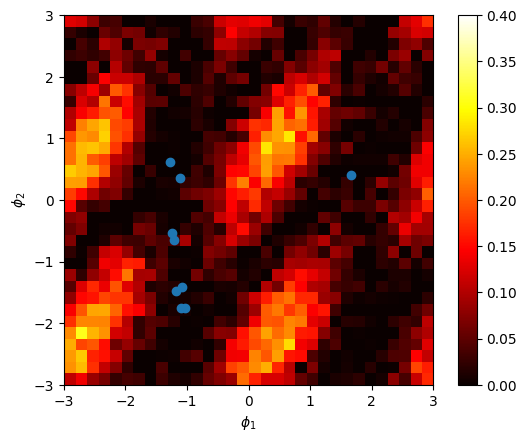

In [9]:
cost_mat, params = run_simulation("var", "var", 0.5*np.pi, 0.5*np.pi, 2)
visualize_cost(cost_mat, params)

Below is after "fixing" the projector matrix

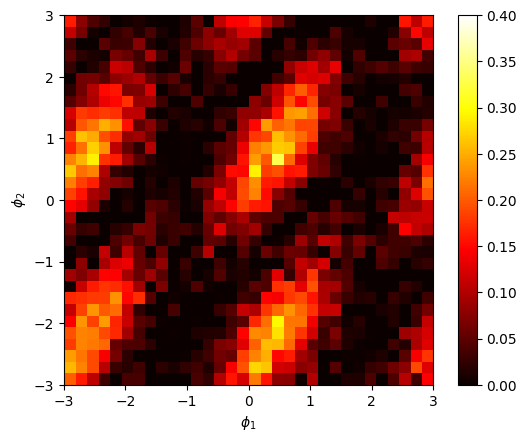

In [9]:
cost_mat, params = run_simulation("var", "var", 0.5*np.pi, 0.5*np.pi, 2)
visualize_cost(cost_mat, params)

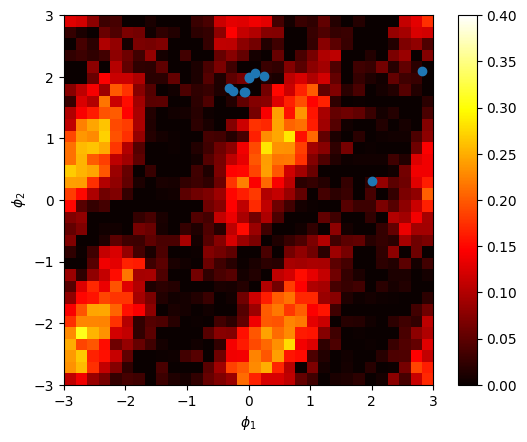

In [16]:
visualize_cost(cost_mat, params)

Before fixing matrix

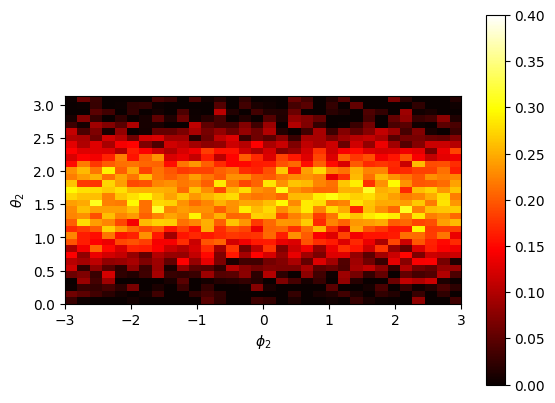

In [15]:
cost_mat, params = run_simulation(0, "var", 0, "var", 2)
visualize_cost(cost_mat, params)

After

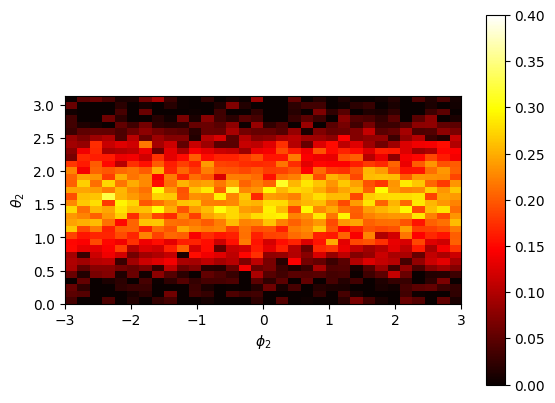

In [10]:
cost_mat, params = run_simulation(0, "var", 0, "var", 2)
visualize_cost(cost_mat, params)

Before

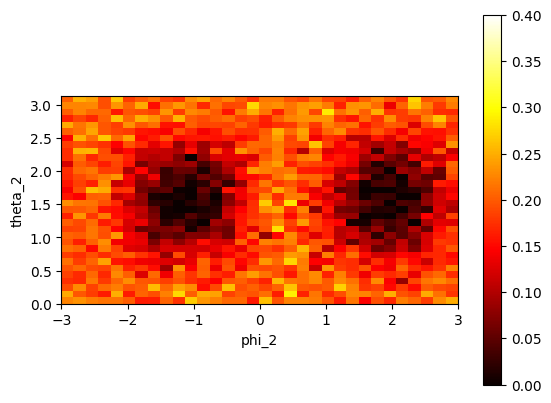

In [63]:
cost_mat, params = run_simulation(0, "var", 0.5*np.pi, "var")
visualize_cost(cost_mat, params)

After

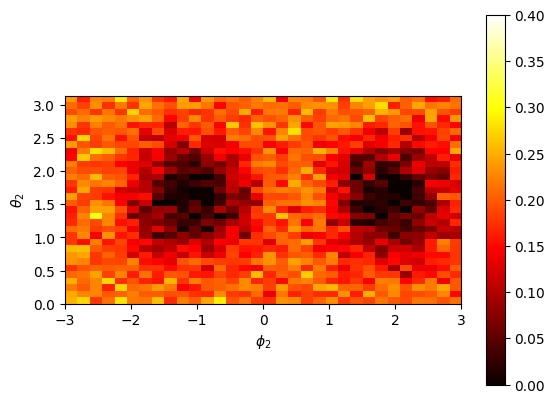

In [11]:
cost_mat, params = run_simulation(0, "var", 0.5*np.pi, "var", 2)
visualize_cost(cost_mat, params)

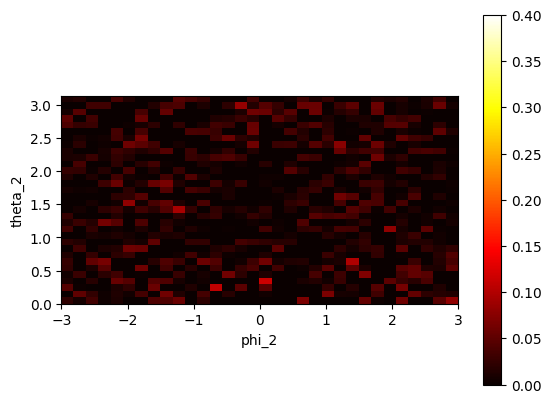

In [66]:
cost_mat, params = run_simulation(0, "var", 0.5*np.pi, "var", 3)
visualize_cost(cost_mat, params)

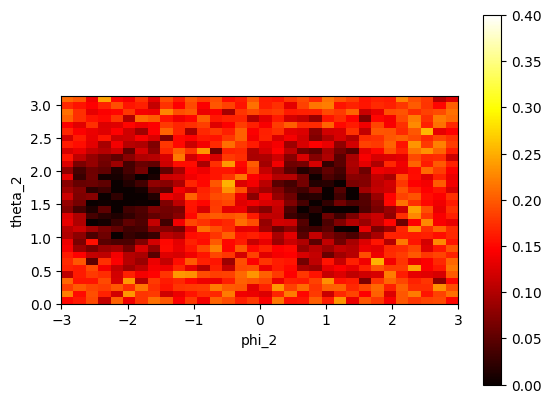

In [67]:
cost_mat, params = run_simulation(0, "var", 0.5*np.pi, "var", 1)
visualize_cost(cost_mat, params)

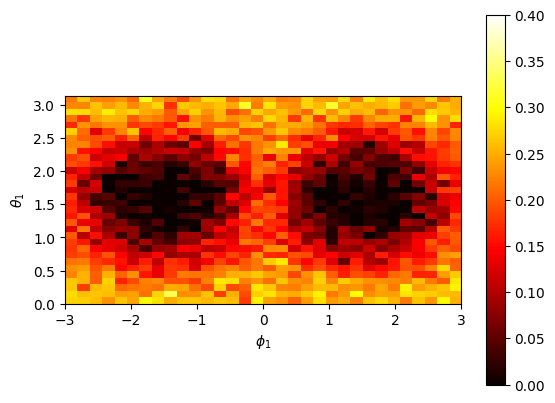

In [18]:
cost_mat, params = run_simulation("var", 0, "var", 0.5*np.pi, 2)
visualize_cost(cost_mat, params)

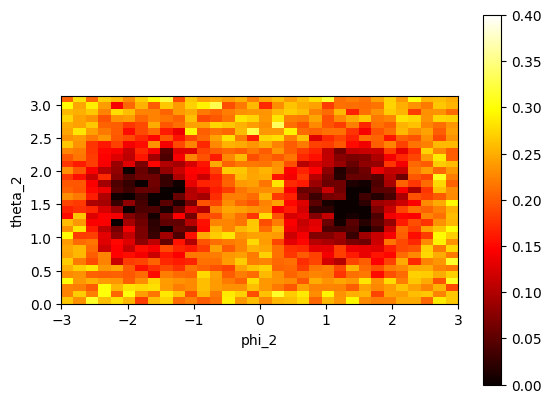

In [69]:
cost_mat, params = run_simulation(0.5*np.pi, "var", 0.5*np.pi, "var", 3)
visualize_cost(cost_mat, params)

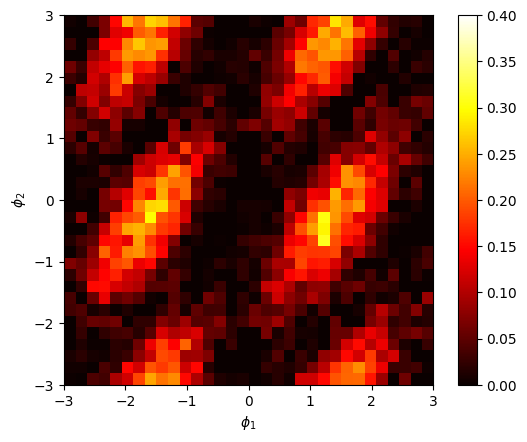

In [9]:
cost_mat, params = run_simulation("var", "var", 0.5*np.pi, 0.5*np.pi, 3)
visualize_cost(cost_mat, params)

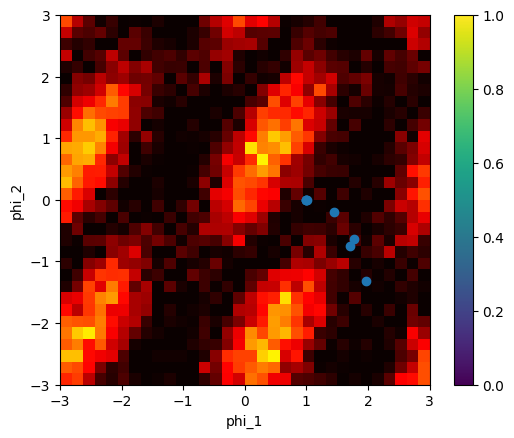

In [12]:
cost_mat, params = run_simulation("var", "var", 0.5*np.pi, 0.5*np.pi, 2)
visualize_cost(cost_mat, params)

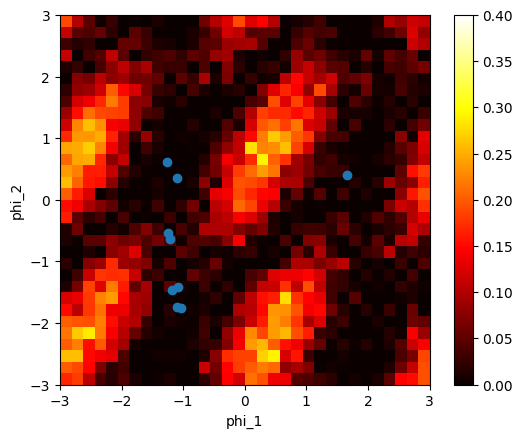

In [17]:
visualize_cost(cost_mat, params)